# Multiclass classification

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import preprocess_chunks_for_multiclass_test_one_handed, concat_chunks_for_feature_extraction, \
    segment_for_null_classification


sample_rate = 50


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]


Preprocess data

In [13]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

0        0
1        1
2        2
3        3
4        4
      ... 
307    307
308    308
309    309
310    310
311    311
Name: index, Length: 312, dtype: int64
312
312


In [14]:
if use_indoor:
    chunks_ocd, chunks_null_class, y_ocd = preprocess_chunks_for_multiclass_test_one_handed(chunks, null_chunks, y)
    # TODO: check the sets of action ids again

#TODO: handle no indoor

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 103, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 228, 229, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 259, 261, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 307, 308, 309, 310, 311]
{312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 325, 326, 327, 329, 340, 341, 342, 343, 344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 356, 357, 358, 359, 360, 361, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 406, 41

In [17]:
labels = y_ocd.loc[:, "label"].squeeze()
assert len(labels) == len(chunks_ocd)

chunks_ocd_segmented, labels_ocd_segmented_multiclass, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size, labels)

assert len(set(labels)) == len(set(labels_ocd_segmented_multiclass))

In [18]:
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

assert len(labels_multi_class_classification) == len(chunks_ocd_segmented) + len(chunks_null_segmented)
assert len(multi_class_df.loc[:, "action_id"].unique()) == len(chunks_ocd_segmented) + len(chunks_null_segmented)

assert len(set(labels_multi_class_classification)) == labels.nunique() + 1
# without null class
"""
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
"""
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

7516


In [20]:
# the one handed activities
assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',}

### Feature extraction for multi class OCD activities incl null

In [21]:
X_multi_class_classification = extract_timeseries_features(multi_class_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


In [53]:
import pandas as pd
print(pd.Series(multi_class_df.loc[:, "action_id"].unique()))

0          (0, 0)
1          (0, 1)
2          (0, 2)
3          (0, 3)
4          (1, 0)
          ...    
6883    (1238, 1)
6884     (931, 0)
6885     (931, 1)
6886    (1239, 0)
6887    (1239, 1)
Length: 6888, dtype: object


### Feature selection for multi class OCD activities incl null

In [26]:
X_multi_class_classification.head()
# TODO: something seems to be weird about the length of the chunks. Some have a length of 200, others 100 and others only 50


impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, set(labels_multi_class_classification))

AssertionError: The type of target vector y must be one of: pandas.Series, numpy.ndarray

In [24]:
X_multi_class_classification_selected

,acceleration y__median,acceleration y__mean,acceleration y__sum_values,acceleration y__minimum,acceleration y__maximum,acceleration x__maximum,acceleration x__mean,acceleration x__sum_values,acceleration x__median,acceleration x__minimum,...,gyroscope z__minimum,gyroscope z__maximum,gyroscope x__minimum,gyroscope x__maximum,acceleration z__maximum,minor,acceleration z__sum_values,acceleration z__mean,acceleration z__median,acceleration z__minimum
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",4.690540,4.711675,235.583759,3.879274,5.721251,5.480186,4.639928,231.996383,4.790815,3.585152,...,-0.341074,0.136636,-0.200415,0.366613,7.625434,6.0,363.497753,7.269955,7.286851,6.880318
"(0, 1)",4.434830,4.455922,222.796088,4.278487,4.800302,5.703636,5.361053,268.052674,5.393883,4.999616,...,-0.125392,0.101273,-0.198078,0.087702,7.064303,6.0,347.243879,6.944878,6.963700,6.784823
"(0, 2)",4.621745,4.661723,233.086158,4.319319,5.049294,5.574845,5.342564,267.128200,5.310844,5.142085,...,-0.084738,0.127797,-0.114419,0.303804,7.124888,5.0,344.730046,6.894601,6.957274,6.525636
"(0, 3)",4.613159,4.669841,233.492068,4.256895,5.117954,5.617421,5.197827,259.891355,5.214433,4.788994,...,-0.191839,0.122563,-0.220643,0.013407,7.446005,6.0,347.117445,6.942349,6.870549,6.527321
"(1, 0)",4.260324,4.393756,219.687811,3.137254,6.251878,10.154037,7.440667,372.033365,7.420933,5.185529,...,-0.020072,0.505471,-0.069364,0.299355,6.784716,6.0,227.372838,4.547457,4.576939,2.616862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1237, 1)",0.445649,0.372851,18.642562,-0.422890,1.155741,0.658143,-0.138250,-6.912524,-0.198044,-0.852834,...,-0.175462,0.011521,-0.068700,0.457737,10.218323,5.0,494.114489,9.882290,9.889692,9.605565
"(1238, 0)",-2.095280,-2.083938,-104.196887,-3.299408,-1.154603,3.184940,1.864970,93.248489,1.861640,0.748580,...,-0.464809,0.411647,0.023032,0.762520,10.877425,5.0,482.650725,9.653015,9.550438,9.036803
"(1238, 1)",-1.247659,-1.247211,-62.360538,-1.450163,-0.885582,1.982647,0.951541,47.577070,0.870566,0.699313,...,-0.117477,0.207017,-0.021881,0.186750,9.934421,5.0,487.559234,9.751185,9.746658,9.372339


In [ ]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

In [ ]:
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])


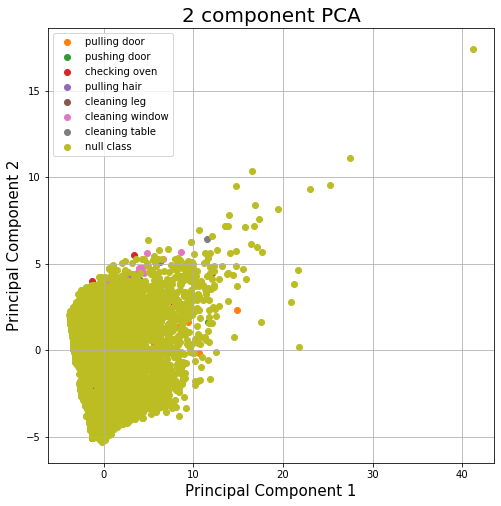

In [42]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])


In [38]:
sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

KeyboardInterrupt: 

In [36]:
labels_multi_class_classification.unique()

array(['pulling door', 'pushing door', 'checking oven', 'pulling hair',
       'cleaning leg', 'cleaning window', 'cleaning table', 'null class'],
      dtype=object)

In [41]:
len(labels_null_segmented)/ len(labels_multi_class_classification)

0.9197711548696115